In [ ]:
#!pip install transformers[torch]

In [ ]:
#%pip install accelerate -U

In [ ]:
#%pip install --upgrade transformers

In [ ]:
#%pip install --upgrade torch

In [ ]:
#%pip install --upgrade accelerate

In [ ]:
#%pip install datasets

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline, DataCollatorWithPadding
from datasets import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-05-26 17:47:49.608800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 17:47:53.776833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Включение отладки CUDA
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# Загрузка данных
train_data_path = '/home/jupyter/datasphere/project/data_sets/fbdataset_train.tsv'
test_data_path = '/home/jupyter/datasphere/project/data_sets/fbdataset_test.tsv'

train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

train_data = shuffle(train_data, random_state=42)
train_data.reset_index(drop=True, inplace=True)
test_data = shuffle(test_data, random_state=42)
test_data.reset_index(drop=True, inplace=True)

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'loc'),
  Text(1, 0, 'finassist'),
  Text(2, 0, 'pay'),
  Text(3, 0, 'dorm'),
  Text(4, 0, 'schedule'),
  Text(5, 0, 'military'),
  Text(6, 0, 'events'),
  Text(7, 0, 'statement_general'),
  Text(8, 0, 'holidays'),
  Text(9, 0, 'grade')])

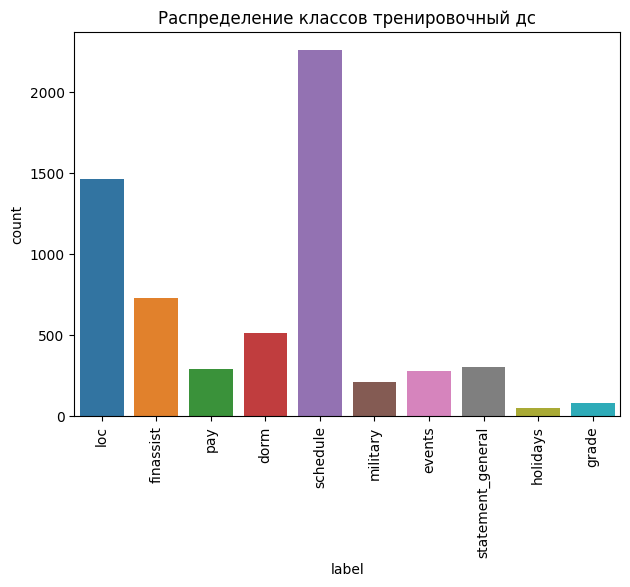

In [6]:
plt.figure
sns.countplot(data = train_data, x = 'label')
plt.title("Распределение классов тренировочный дс")
plt.tight_layout()
plt.xticks(rotation=90)

In [7]:
# Определение словарей меток
LabelDict = {
    0: 'statement_general',
    1: 'dorm',
    2: 'events',
    3: 'finassist',
    4: 'grade',
    5: 'loc',
    6: 'military',
    7: 'holidays',
    8: 'pay',
    9: 'schedule',
}
ReplaceDict = {
    "statement_general": 0,
    "dorm": 1,
    "events": 2,
    "finassist": 3,
    "grade": 4,
    "loc": 5,
    "military": 6,
    "holidays": 7,
    "pay": 8,
    "schedule": 9,
}

In [8]:
train_data["label"] = train_data["label"].replace(ReplaceDict)
test_data["label"] = test_data["label"].replace(ReplaceDict)

In [9]:
# Проверка уникальных значений меток
print("Уникальные значения меток в обучающем наборе:", train_data["label"].unique())
print("Уникальные значения меток в тестовом наборе:", test_data["label"].unique())

Уникальные значения меток в обучающем наборе: [5 3 8 1 9 6 2 0 7 4]
Уникальные значения меток в тестовом наборе: [ 5.  3.  9.  1.  0.  2.  8.  4.  6. nan  7.]


In [10]:
# Удаление строк с NaN значениями в метках
train_data.dropna(subset=["label"], inplace=True)
test_data.dropna(subset=["label"], inplace=True)

# Преобразование меток в целочисленный формат
train_data["label"] = train_data["label"].astype(int)
test_data["label"] = test_data["label"].astype(int)

In [11]:
# Проверка уникальных значений меток
print("Уникальные значения меток в обучающем наборе:", train_data["label"].unique())
print("Уникальные значения меток в тестовом наборе:", test_data["label"].unique())

Уникальные значения меток в обучающем наборе: [5 3 8 1 9 6 2 0 7 4]
Уникальные значения меток в тестовом наборе: [5 3 9 1 0 2 8 4 6 7]


In [12]:
# Функции для обработки данных и визуализации
def convert_to_dataset(data, tokenizer, max_len=128):
    texts = data['text'].tolist()
    labels = data['label'].tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels).long()
    })
    return dataset, labels

In [13]:
def compute_class_weights(labels):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float)

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
def plot_training_loss(trainer_state, title='Training and Validation Loss'):
    train_loss = [log['loss'] for log in trainer_state.log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in trainer_state.log_history if 'eval_loss' in log]
    plt.figure(figsize=(10, 8))
    plt.plot(train_loss, label='Training Loss')
    if eval_loss:
        plt.plot(eval_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 11/1161 [00:01<02:21,  8.11it/s]

{'loss': 2.334, 'grad_norm': 11.265993118286133, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.03}


  2%|▏         | 21/1161 [00:02<02:19,  8.16it/s]

{'loss': 2.3088, 'grad_norm': 6.245600700378418, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.05}


  3%|▎         | 30/1161 [00:03<02:17,  8.21it/s]

{'loss': 2.3408, 'grad_norm': 7.160863399505615, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.08}


  3%|▎         | 40/1161 [00:04<02:14,  8.34it/s]

{'loss': 2.3416, 'grad_norm': 5.567075252532959, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.1}


  4%|▍         | 50/1161 [00:06<02:13,  8.35it/s]

{'loss': 2.3337, 'grad_norm': 6.239689350128174, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.13}


  5%|▌         | 60/1161 [00:07<02:11,  8.37it/s]

{'loss': 2.3383, 'grad_norm': 7.021489143371582, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.16}


  6%|▌         | 70/1161 [00:08<02:10,  8.36it/s]

{'loss': 2.311, 'grad_norm': 9.041400909423828, 'learning_rate': 1.4000000000000001e-06, 'epoch': 0.18}


  7%|▋         | 80/1161 [00:09<02:08,  8.43it/s]

{'loss': 2.2856, 'grad_norm': 7.794925212860107, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.21}


  8%|▊         | 90/1161 [00:10<02:08,  8.30it/s]

{'loss': 2.2576, 'grad_norm': 6.9753007888793945, 'learning_rate': 1.8000000000000001e-06, 'epoch': 0.23}


  9%|▊         | 101/1161 [00:12<02:05,  8.42it/s]

{'loss': 2.2711, 'grad_norm': 6.06093692779541, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.26}


 10%|▉         | 111/1161 [00:13<02:07,  8.25it/s]

{'loss': 2.224, 'grad_norm': 8.295572280883789, 'learning_rate': 2.2e-06, 'epoch': 0.28}


 10%|█         | 121/1161 [00:14<02:06,  8.20it/s]

{'loss': 2.2068, 'grad_norm': 10.225296020507812, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.31}


 11%|█▏        | 131/1161 [00:15<02:02,  8.43it/s]

{'loss': 2.2082, 'grad_norm': 8.235527992248535, 'learning_rate': 2.6e-06, 'epoch': 0.34}


 12%|█▏        | 141/1161 [00:16<02:02,  8.32it/s]

{'loss': 2.1561, 'grad_norm': 10.455652236938477, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.36}


 13%|█▎        | 151/1161 [00:18<02:02,  8.25it/s]

{'loss': 2.1728, 'grad_norm': 15.180804252624512, 'learning_rate': 3e-06, 'epoch': 0.39}


 14%|█▍        | 161/1161 [00:19<02:00,  8.31it/s]

{'loss': 2.1428, 'grad_norm': 11.522047996520996, 'learning_rate': 3.2000000000000003e-06, 'epoch': 0.41}


 15%|█▍        | 171/1161 [00:20<01:58,  8.33it/s]

{'loss': 2.0796, 'grad_norm': 14.36402416229248, 'learning_rate': 3.4000000000000005e-06, 'epoch': 0.44}


 16%|█▌        | 181/1161 [00:21<01:56,  8.38it/s]

{'loss': 2.0706, 'grad_norm': 10.82556438446045, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.47}


 16%|█▋        | 191/1161 [00:22<01:56,  8.29it/s]

{'loss': 1.9857, 'grad_norm': 11.287236213684082, 'learning_rate': 3.8000000000000005e-06, 'epoch': 0.49}


 17%|█▋        | 200/1161 [00:24<01:54,  8.42it/s]

{'loss': 1.8181, 'grad_norm': 10.461265563964844, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.52}


 18%|█▊        | 211/1161 [00:25<01:56,  8.19it/s]

{'loss': 1.7672, 'grad_norm': 9.398736000061035, 'learning_rate': 4.2000000000000004e-06, 'epoch': 0.54}


 19%|█▉        | 221/1161 [00:26<01:52,  8.34it/s]

{'loss': 1.8713, 'grad_norm': 12.142624855041504, 'learning_rate': 4.4e-06, 'epoch': 0.57}


 20%|█▉        | 230/1161 [00:27<01:50,  8.41it/s]

{'loss': 1.8104, 'grad_norm': 25.03551483154297, 'learning_rate': 4.600000000000001e-06, 'epoch': 0.59}


 21%|██        | 240/1161 [00:28<01:49,  8.40it/s]

{'loss': 1.9241, 'grad_norm': 10.204648971557617, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.62}


 22%|██▏       | 250/1161 [00:29<01:47,  8.44it/s]

{'loss': 1.6564, 'grad_norm': 7.7614240646362305, 'learning_rate': 5e-06, 'epoch': 0.65}


 22%|██▏       | 260/1161 [00:31<01:46,  8.43it/s]

{'loss': 1.5542, 'grad_norm': 13.064299583435059, 'learning_rate': 5.2e-06, 'epoch': 0.67}


 23%|██▎       | 270/1161 [00:32<01:45,  8.46it/s]

{'loss': 1.7638, 'grad_norm': 14.956003189086914, 'learning_rate': 5.400000000000001e-06, 'epoch': 0.7}


 24%|██▍       | 280/1161 [00:33<01:45,  8.33it/s]

{'loss': 1.4437, 'grad_norm': 11.04605484008789, 'learning_rate': 5.600000000000001e-06, 'epoch': 0.72}


 25%|██▍       | 290/1161 [00:34<01:43,  8.43it/s]

{'loss': 1.366, 'grad_norm': 17.67290687561035, 'learning_rate': 5.8e-06, 'epoch': 0.75}


 26%|██▌       | 300/1161 [00:35<01:42,  8.43it/s]

{'loss': 1.5272, 'grad_norm': 13.351090431213379, 'learning_rate': 6e-06, 'epoch': 0.78}


 27%|██▋       | 310/1161 [00:37<01:40,  8.50it/s]

{'loss': 1.2863, 'grad_norm': 33.148990631103516, 'learning_rate': 6.200000000000001e-06, 'epoch': 0.8}


 28%|██▊       | 320/1161 [00:38<01:39,  8.43it/s]

{'loss': 1.07, 'grad_norm': 8.4498872756958, 'learning_rate': 6.4000000000000006e-06, 'epoch': 0.83}


 28%|██▊       | 330/1161 [00:39<01:38,  8.39it/s]

{'loss': 1.0509, 'grad_norm': 11.637197494506836, 'learning_rate': 6.600000000000001e-06, 'epoch': 0.85}


 29%|██▉       | 341/1161 [00:40<01:38,  8.32it/s]

{'loss': 1.2771, 'grad_norm': 22.194965362548828, 'learning_rate': 6.800000000000001e-06, 'epoch': 0.88}


 30%|███       | 351/1161 [00:42<01:36,  8.37it/s]

{'loss': 1.089, 'grad_norm': 24.265117645263672, 'learning_rate': 7e-06, 'epoch': 0.9}


 31%|███       | 361/1161 [00:43<01:35,  8.36it/s]

{'loss': 0.9337, 'grad_norm': 19.59955406188965, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.93}


 32%|███▏      | 371/1161 [00:44<01:34,  8.35it/s]

{'loss': 0.7157, 'grad_norm': 7.939815998077393, 'learning_rate': 7.4e-06, 'epoch': 0.96}


 33%|███▎      | 381/1161 [00:45<01:33,  8.36it/s]

{'loss': 0.8292, 'grad_norm': 16.642446517944336, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.98}


 81%|████████▏ | 22/27 [00:00<00:00, 36.67it/s]
                                                  
100%|██████████| 27/27 [00:00<00:00, 36.55it/s]
                                               

{'eval_loss': 1.0650651454925537, 'eval_runtime': 0.7527, 'eval_samples_per_second': 555.302, 'eval_steps_per_second': 35.869, 'epoch': 1.0}


 34%|███▎      | 390/1161 [01:57<2:14:23, 10.46s/it]

{'loss': 0.6428, 'grad_norm': 6.3555006980896, 'learning_rate': 7.800000000000002e-06, 'epoch': 1.01}


 34%|███▍      | 400/1161 [01:58<05:11,  2.44it/s]  

{'loss': 0.547, 'grad_norm': 7.713268756866455, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.03}


 35%|███▌      | 410/1161 [01:59<01:34,  7.95it/s]

{'loss': 0.4722, 'grad_norm': 12.773462295532227, 'learning_rate': 8.2e-06, 'epoch': 1.06}


 36%|███▌      | 420/1161 [02:00<01:28,  8.36it/s]

{'loss': 0.4247, 'grad_norm': 3.3208014965057373, 'learning_rate': 8.400000000000001e-06, 'epoch': 1.09}


 37%|███▋      | 430/1161 [02:01<01:27,  8.33it/s]

{'loss': 0.331, 'grad_norm': 4.05006217956543, 'learning_rate': 8.6e-06, 'epoch': 1.11}


 38%|███▊      | 440/1161 [02:02<01:26,  8.33it/s]

{'loss': 0.2981, 'grad_norm': 2.1563987731933594, 'learning_rate': 8.8e-06, 'epoch': 1.14}


 39%|███▉      | 450/1161 [02:04<01:24,  8.37it/s]

{'loss': 0.2832, 'grad_norm': 3.9821038246154785, 'learning_rate': 9e-06, 'epoch': 1.16}


 40%|███▉      | 460/1161 [02:05<01:23,  8.38it/s]

{'loss': 0.22, 'grad_norm': 3.5406670570373535, 'learning_rate': 9.200000000000002e-06, 'epoch': 1.19}


 40%|████      | 470/1161 [02:06<01:23,  8.26it/s]

{'loss': 0.2801, 'grad_norm': 6.303701400756836, 'learning_rate': 9.4e-06, 'epoch': 1.21}


 41%|████▏     | 480/1161 [02:07<01:22,  8.30it/s]

{'loss': 0.1936, 'grad_norm': 4.995035171508789, 'learning_rate': 9.600000000000001e-06, 'epoch': 1.24}


 42%|████▏     | 490/1161 [02:09<01:20,  8.38it/s]

{'loss': 0.2012, 'grad_norm': 1.9682495594024658, 'learning_rate': 9.800000000000001e-06, 'epoch': 1.27}


 43%|████▎     | 500/1161 [02:10<01:19,  8.31it/s]

{'loss': 0.1603, 'grad_norm': 4.870064735412598, 'learning_rate': 1e-05, 'epoch': 1.29}


 44%|████▍     | 510/1161 [02:11<01:17,  8.37it/s]

{'loss': 0.1613, 'grad_norm': 1.832427740097046, 'learning_rate': 9.848714069591528e-06, 'epoch': 1.32}


 45%|████▍     | 520/1161 [02:12<01:16,  8.40it/s]

{'loss': 0.1139, 'grad_norm': 1.4793494939804077, 'learning_rate': 9.697428139183058e-06, 'epoch': 1.34}


 46%|████▌     | 530/1161 [02:13<01:14,  8.44it/s]

{'loss': 0.0891, 'grad_norm': 2.001539468765259, 'learning_rate': 9.546142208774585e-06, 'epoch': 1.37}


 47%|████▋     | 540/1161 [02:15<01:13,  8.47it/s]

{'loss': 0.1252, 'grad_norm': 0.49955758452415466, 'learning_rate': 9.394856278366113e-06, 'epoch': 1.4}


 47%|████▋     | 550/1161 [02:16<01:12,  8.45it/s]

{'loss': 0.084, 'grad_norm': 0.7396667003631592, 'learning_rate': 9.243570347957642e-06, 'epoch': 1.42}


 48%|████▊     | 560/1161 [02:17<01:11,  8.40it/s]

{'loss': 0.0851, 'grad_norm': 0.45786136388778687, 'learning_rate': 9.09228441754917e-06, 'epoch': 1.45}


 49%|████▉     | 570/1161 [02:18<01:10,  8.40it/s]

{'loss': 0.0547, 'grad_norm': 0.7506171464920044, 'learning_rate': 8.940998487140697e-06, 'epoch': 1.47}


 50%|████▉     | 580/1161 [02:19<01:08,  8.43it/s]

{'loss': 0.0466, 'grad_norm': 0.4385451078414917, 'learning_rate': 8.789712556732225e-06, 'epoch': 1.5}


 51%|█████     | 590/1161 [02:21<01:08,  8.37it/s]

{'loss': 0.0494, 'grad_norm': 1.4287998676300049, 'learning_rate': 8.638426626323752e-06, 'epoch': 1.52}


 52%|█████▏    | 600/1161 [02:22<01:06,  8.48it/s]

{'loss': 0.0446, 'grad_norm': 0.2719308137893677, 'learning_rate': 8.48714069591528e-06, 'epoch': 1.55}


 53%|█████▎    | 610/1161 [02:23<01:05,  8.36it/s]

{'loss': 0.054, 'grad_norm': 0.23317338526248932, 'learning_rate': 8.335854765506809e-06, 'epoch': 1.58}


 53%|█████▎    | 620/1161 [02:24<01:04,  8.33it/s]

{'loss': 0.0403, 'grad_norm': 0.8865625262260437, 'learning_rate': 8.184568835098336e-06, 'epoch': 1.6}


 54%|█████▍    | 630/1161 [02:25<01:03,  8.39it/s]

{'loss': 0.0382, 'grad_norm': 0.554732084274292, 'learning_rate': 8.033282904689864e-06, 'epoch': 1.63}


 55%|█████▌    | 640/1161 [02:27<01:02,  8.32it/s]

{'loss': 0.0456, 'grad_norm': 0.2976745069026947, 'learning_rate': 7.881996974281393e-06, 'epoch': 1.65}


 56%|█████▌    | 650/1161 [02:28<01:01,  8.31it/s]

{'loss': 0.0286, 'grad_norm': 0.17794029414653778, 'learning_rate': 7.73071104387292e-06, 'epoch': 1.68}


 57%|█████▋    | 661/1161 [02:52<59:24,  7.13s/it]

{'loss': 0.0289, 'grad_norm': 0.3802720606327057, 'learning_rate': 7.579425113464448e-06, 'epoch': 1.71}


 58%|█████▊    | 671/1161 [02:54<02:36,  3.14it/s]

{'loss': 0.0265, 'grad_norm': 0.21597786247730255, 'learning_rate': 7.428139183055977e-06, 'epoch': 1.73}


 59%|█████▊    | 681/1161 [02:55<01:01,  7.74it/s]

{'loss': 0.0478, 'grad_norm': 0.769994854927063, 'learning_rate': 7.276853252647504e-06, 'epoch': 1.76}


 60%|█████▉    | 691/1161 [02:56<00:56,  8.29it/s]

{'loss': 0.0227, 'grad_norm': 0.3169330656528473, 'learning_rate': 7.125567322239032e-06, 'epoch': 1.78}


 60%|██████    | 701/1161 [02:57<00:55,  8.36it/s]

{'loss': 0.0376, 'grad_norm': 17.623695373535156, 'learning_rate': 6.974281391830561e-06, 'epoch': 1.81}


 61%|██████    | 711/1161 [02:58<00:54,  8.25it/s]

{'loss': 0.0336, 'grad_norm': 0.19896167516708374, 'learning_rate': 6.8229954614220885e-06, 'epoch': 1.83}


 62%|██████▏   | 721/1161 [03:00<00:52,  8.38it/s]

{'loss': 0.0305, 'grad_norm': 0.5741164684295654, 'learning_rate': 6.671709531013616e-06, 'epoch': 1.86}


 63%|██████▎   | 731/1161 [03:01<00:52,  8.18it/s]

{'loss': 0.0189, 'grad_norm': 0.1828497052192688, 'learning_rate': 6.520423600605144e-06, 'epoch': 1.89}


 64%|██████▍   | 741/1161 [03:02<00:50,  8.31it/s]

{'loss': 0.0178, 'grad_norm': 0.30751439929008484, 'learning_rate': 6.369137670196672e-06, 'epoch': 1.91}


 65%|██████▍   | 751/1161 [03:03<00:50,  8.12it/s]

{'loss': 0.0725, 'grad_norm': 6.488158226013184, 'learning_rate': 6.2178517397881995e-06, 'epoch': 1.94}


 66%|██████▌   | 761/1161 [03:04<00:48,  8.30it/s]

{'loss': 0.018, 'grad_norm': 0.2184593677520752, 'learning_rate': 6.066565809379729e-06, 'epoch': 1.96}


 66%|██████▋   | 771/1161 [03:06<00:47,  8.27it/s]

{'loss': 0.0367, 'grad_norm': 0.1981356292963028, 'learning_rate': 5.915279878971256e-06, 'epoch': 1.99}


 81%|████████▏ | 22/27 [00:00<00:00, 36.78it/s]
                                                  
100%|██████████| 27/27 [00:00<00:00, 36.58it/s]
                                               

{'eval_loss': 1.2792912721633911, 'eval_runtime': 0.7555, 'eval_samples_per_second': 553.292, 'eval_steps_per_second': 35.739, 'epoch': 2.0}


 67%|██████▋   | 780/1161 [04:17<23:17,  3.67s/it]  

{'loss': 0.0162, 'grad_norm': 0.8375017642974854, 'learning_rate': 5.763993948562784e-06, 'epoch': 2.02}


 68%|██████▊   | 790/1161 [04:18<01:21,  4.54it/s]

{'loss': 0.0208, 'grad_norm': 0.12233500927686691, 'learning_rate': 5.612708018154312e-06, 'epoch': 2.04}


 69%|██████▉   | 800/1161 [04:19<00:44,  8.07it/s]

{'loss': 0.0332, 'grad_norm': 0.13445629179477692, 'learning_rate': 5.4614220877458406e-06, 'epoch': 2.07}


 70%|██████▉   | 810/1161 [04:21<00:42,  8.25it/s]

{'loss': 0.0159, 'grad_norm': 0.4917682111263275, 'learning_rate': 5.310136157337368e-06, 'epoch': 2.09}


 71%|███████   | 820/1161 [04:22<00:40,  8.33it/s]

{'loss': 0.0153, 'grad_norm': 0.28610140085220337, 'learning_rate': 5.1588502269288965e-06, 'epoch': 2.12}


 71%|███████▏  | 830/1161 [04:23<00:39,  8.42it/s]

{'loss': 0.014, 'grad_norm': 0.10679155588150024, 'learning_rate': 5.007564296520424e-06, 'epoch': 2.14}


 72%|███████▏  | 840/1161 [04:24<00:37,  8.48it/s]

{'loss': 0.0855, 'grad_norm': 0.24691681563854218, 'learning_rate': 4.856278366111952e-06, 'epoch': 2.17}


 73%|███████▎  | 850/1161 [04:25<00:37,  8.36it/s]

{'loss': 0.0271, 'grad_norm': 0.29147252440452576, 'learning_rate': 4.70499243570348e-06, 'epoch': 2.2}


 74%|███████▍  | 860/1161 [04:27<00:35,  8.48it/s]

{'loss': 0.0129, 'grad_norm': 0.10288859903812408, 'learning_rate': 4.553706505295008e-06, 'epoch': 2.22}


 75%|███████▍  | 870/1161 [04:28<00:34,  8.48it/s]

{'loss': 0.0132, 'grad_norm': 0.09865736216306686, 'learning_rate': 4.402420574886536e-06, 'epoch': 2.25}


 76%|███████▌  | 880/1161 [04:29<00:33,  8.48it/s]

{'loss': 0.0138, 'grad_norm': 0.16532307863235474, 'learning_rate': 4.2511346444780634e-06, 'epoch': 2.27}


 77%|███████▋  | 890/1161 [04:30<00:32,  8.46it/s]

{'loss': 0.0211, 'grad_norm': 0.17717696726322174, 'learning_rate': 4.099848714069592e-06, 'epoch': 2.3}


 78%|███████▊  | 900/1161 [04:31<00:31,  8.36it/s]

{'loss': 0.0124, 'grad_norm': 0.45632097125053406, 'learning_rate': 3.94856278366112e-06, 'epoch': 2.33}


 78%|███████▊  | 910/1161 [04:33<00:30,  8.29it/s]

{'loss': 0.0124, 'grad_norm': 0.14568305015563965, 'learning_rate': 3.7972768532526477e-06, 'epoch': 2.35}


 79%|███████▉  | 920/1161 [04:34<00:28,  8.38it/s]

{'loss': 0.013, 'grad_norm': 0.09170397371053696, 'learning_rate': 3.6459909228441757e-06, 'epoch': 2.38}


 80%|████████  | 930/1161 [04:35<00:27,  8.42it/s]

{'loss': 0.0145, 'grad_norm': 0.0876474380493164, 'learning_rate': 3.4947049924357037e-06, 'epoch': 2.4}


 81%|████████  | 940/1161 [04:36<00:26,  8.47it/s]

{'loss': 0.0128, 'grad_norm': 0.1139509305357933, 'learning_rate': 3.3434190620272316e-06, 'epoch': 2.43}


 82%|████████▏ | 951/1161 [04:38<00:25,  8.32it/s]

{'loss': 0.0116, 'grad_norm': 0.10181310027837753, 'learning_rate': 3.19213313161876e-06, 'epoch': 2.45}


 83%|████████▎ | 961/1161 [04:39<00:24,  8.32it/s]

{'loss': 0.0125, 'grad_norm': 0.08736176043748856, 'learning_rate': 3.0408472012102876e-06, 'epoch': 2.48}


 84%|████████▎ | 971/1161 [04:40<00:22,  8.30it/s]

{'loss': 0.0249, 'grad_norm': 0.09542738646268845, 'learning_rate': 2.8895612708018155e-06, 'epoch': 2.51}


 84%|████████▍ | 981/1161 [04:41<00:21,  8.30it/s]

{'loss': 0.0106, 'grad_norm': 0.09743071347475052, 'learning_rate': 2.738275340393344e-06, 'epoch': 2.53}


 85%|████████▌ | 991/1161 [04:42<00:20,  8.30it/s]

{'loss': 0.0103, 'grad_norm': 0.11094261705875397, 'learning_rate': 2.5869894099848714e-06, 'epoch': 2.56}


 86%|████████▌ | 1001/1161 [04:44<00:19,  8.37it/s]

{'loss': 0.0186, 'grad_norm': 0.11165769398212433, 'learning_rate': 2.4357034795763994e-06, 'epoch': 2.58}


 87%|████████▋ | 1011/1161 [04:45<00:18,  8.28it/s]

{'loss': 0.0109, 'grad_norm': 0.09279477596282959, 'learning_rate': 2.284417549167928e-06, 'epoch': 2.61}


 88%|████████▊ | 1021/1161 [04:46<00:16,  8.40it/s]

{'loss': 0.0113, 'grad_norm': 0.0767713338136673, 'learning_rate': 2.1331316187594558e-06, 'epoch': 2.64}


 89%|████████▉ | 1031/1161 [04:47<00:15,  8.29it/s]

{'loss': 0.0114, 'grad_norm': 0.11378929764032364, 'learning_rate': 1.9818456883509833e-06, 'epoch': 2.66}


 90%|████████▉ | 1041/1161 [04:48<00:14,  8.31it/s]

{'loss': 0.0133, 'grad_norm': 7.695567607879639, 'learning_rate': 1.8305597579425117e-06, 'epoch': 2.69}


 91%|█████████ | 1051/1161 [04:50<00:13,  8.39it/s]

{'loss': 0.0106, 'grad_norm': 0.09800669550895691, 'learning_rate': 1.6792738275340394e-06, 'epoch': 2.71}


 91%|█████████▏| 1060/1161 [04:51<00:12,  8.32it/s]

{'loss': 0.0104, 'grad_norm': 0.08725560456514359, 'learning_rate': 1.5279878971255674e-06, 'epoch': 2.74}


 92%|█████████▏| 1070/1161 [04:52<00:10,  8.49it/s]

{'loss': 0.0106, 'grad_norm': 0.09065096825361252, 'learning_rate': 1.3767019667170956e-06, 'epoch': 2.76}


 93%|█████████▎| 1080/1161 [04:53<00:09,  8.47it/s]

{'loss': 0.0109, 'grad_norm': 0.10419528186321259, 'learning_rate': 1.2254160363086235e-06, 'epoch': 2.79}


 94%|█████████▍| 1090/1161 [04:54<00:08,  8.35it/s]

{'loss': 0.0112, 'grad_norm': 0.07204824686050415, 'learning_rate': 1.0741301059001513e-06, 'epoch': 2.82}


 95%|█████████▍| 1100/1161 [04:55<00:07,  8.17it/s]

{'loss': 0.0097, 'grad_norm': 0.0795566588640213, 'learning_rate': 9.228441754916794e-07, 'epoch': 2.84}


 96%|█████████▌| 1110/1161 [04:57<00:06,  8.38it/s]

{'loss': 0.0112, 'grad_norm': 0.08621450513601303, 'learning_rate': 7.715582450832073e-07, 'epoch': 2.87}


 96%|█████████▋| 1120/1161 [04:58<00:04,  8.42it/s]

{'loss': 0.0424, 'grad_norm': 6.119118690490723, 'learning_rate': 6.202723146747353e-07, 'epoch': 2.89}


 97%|█████████▋| 1130/1161 [04:59<00:03,  8.48it/s]

{'loss': 0.0109, 'grad_norm': 0.12735295295715332, 'learning_rate': 4.689863842662633e-07, 'epoch': 2.92}


 98%|█████████▊| 1140/1161 [05:00<00:02,  8.30it/s]

{'loss': 0.0428, 'grad_norm': 0.13719789683818817, 'learning_rate': 3.177004538577912e-07, 'epoch': 2.95}


 99%|█████████▉| 1150/1161 [05:01<00:01,  8.29it/s]

{'loss': 0.0106, 'grad_norm': 0.10959307104349136, 'learning_rate': 1.6641452344931923e-07, 'epoch': 2.97}


100%|█████████▉| 1160/1161 [05:03<00:00,  8.28it/s]

{'loss': 0.0108, 'grad_norm': 0.10437607020139694, 'learning_rate': 1.5128593040847203e-08, 'epoch': 3.0}


 81%|████████▏ | 22/27 [00:00<00:00, 35.55it/s]
                                                   
100%|██████████| 27/27 [00:00<00:00, 35.44it/s]
                                               

{'eval_loss': 1.2888023853302002, 'eval_runtime': 0.773, 'eval_samples_per_second': 540.742, 'eval_steps_per_second': 34.928, 'epoch': 3.0}


100%|██████████| 1161/1161 [06:36<00:00,  2.93it/s]

{'train_runtime': 396.5104, 'train_samples_per_second': 46.826, 'train_steps_per_second': 2.928, 'train_loss': 0.6486896917698817, 'epoch': 3.0}



100%|██████████| 27/27 [00:00<00:00, 36.30it/s]


                   precision    recall  f1-score   support

statement_general       0.96      1.00      0.98        43
             dorm       0.88      1.00      0.93        49
           events       0.97      0.72      0.82        39
        finassist       0.84      0.96      0.90        49
            grade       1.00      0.50      0.67        14
              loc       0.84      0.84      0.84        85
         military       0.67      0.80      0.73        20
         holidays       0.71      0.42      0.53        12
              pay       0.96      0.81      0.88        31
         schedule       0.92      1.00      0.96        76

         accuracy                           0.88       418
        macro avg       0.87      0.80      0.82       418
     weighted avg       0.88      0.88      0.87       418



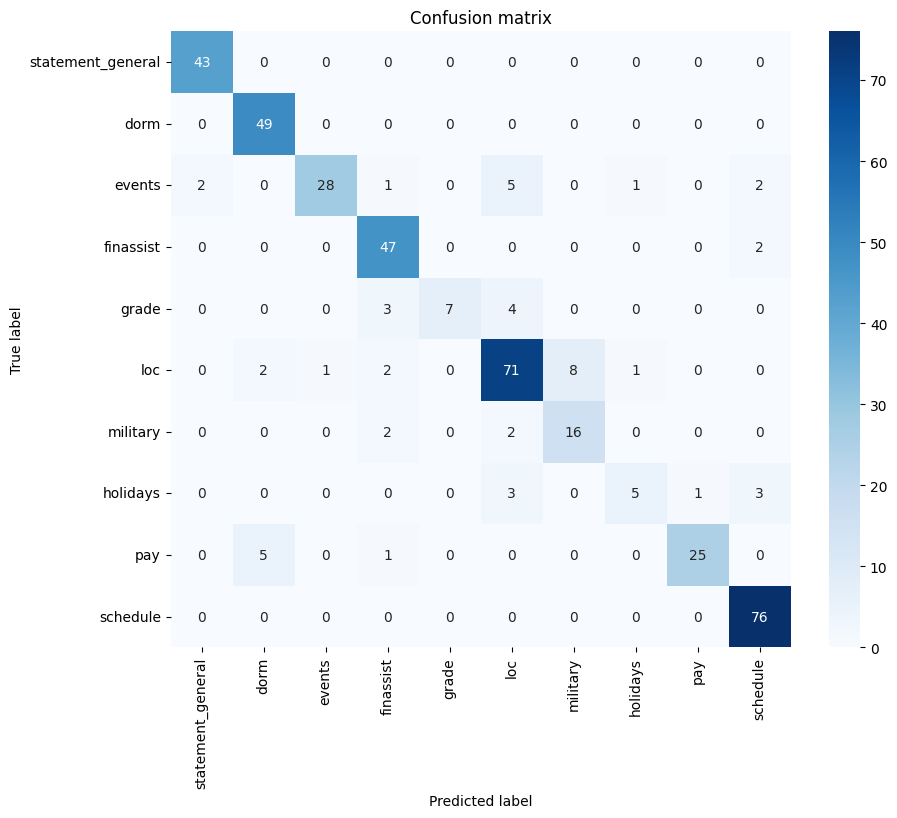

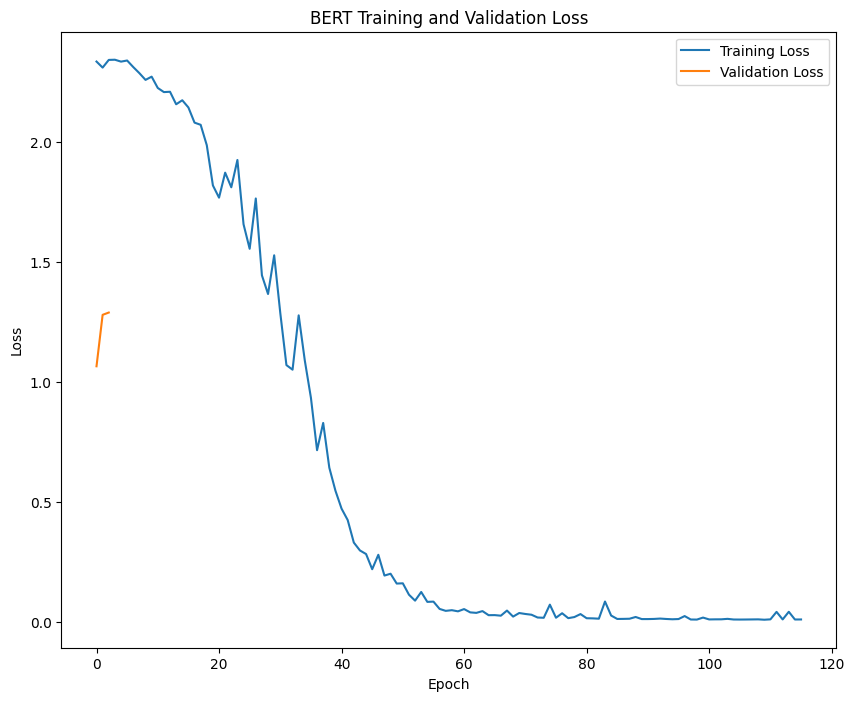

In [33]:
# Определение класса CustomTrainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(self.args.device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(self.args.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Определение устройства (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение и обучение модели BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=10).to(device)

train_dataset, train_labels = convert_to_dataset(train_data, tokenizer)
test_dataset, test_labels = convert_to_dataset(test_data, tokenizer)

# Проверка меток на валидность
assert all(0 <= label < 10 for label in train_labels), "Ошибка: Некорректные метки в обучающем наборе"
assert all(0 <= label < 10 for label in test_labels), "Ошибка: Некорректные метки в тестовом наборе"


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=1e-5,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    lr_scheduler_type='linear'
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = compute_class_weights(train_labels)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

trainer.train()

trainer.save_model('best_model_bert_with_preprocess3')
tokenizer.save_pretrained('best_model_bert_with_preprocess3')

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
print(classification_report(test_labels, y_pred, target_names=list(ReplaceDict.keys())))

plot_confusion_matrix(test_labels, y_pred, classes=list(ReplaceDict.keys()))

plot_training_loss(trainer.state, title='BERT Training and Validation Loss')


## Old

In [ ]:
# # Определение и обучение модели BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=10)

# train_dataset, train_labels = convert_to_dataset(train_data, tokenizer)
# test_dataset, test_labels = convert_to_dataset(test_data, tokenizer)

# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     save_strategy='epoch'
# )

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# class_weights = compute_class_weights(train_labels)

# def compute_loss(model, inputs, return_outputs=False):
#     labels = inputs.get("labels")
#     outputs = model(**inputs)
#     logits = outputs.get("logits")
#     loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
#     loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     data_collator=data_collator,
#     compute_loss=compute_loss
# )

# trainer.train()

# trainer.save_model('best_model_bert')

# predictions = trainer.predict(test_dataset)
# y_pred = np.argmax(predictions.predictions, axis=1)
# print(classification_report(test_labels, y_pred, target_names=list(ReplaceDict.keys())))

# plot_confusion_matrix(test_labels, y_pred, classes=list(ReplaceDict.keys()))

# plot_training_loss(trainer.state, title='BERT Training and Validation Loss')

In [ ]:
# # Определение и обучение модели RoBERTa
# from transformers import RobertaTokenizer, RobertaForSequenceClassification

# roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=10)

# train_dataset, train_labels = convert_to_dataset(train_data, roberta_tokenizer)
# test_dataset, test_labels = convert_to_dataset(test_data, roberta_tokenizer)

# class_weights = compute_class_weights(train_labels)

# def compute_loss(model, inputs, return_outputs=False):
#     labels = inputs.get("labels")
#     outputs = model(**inputs)
#     logits = outputs.get("logits")
#     loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
#     loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss

# roberta_trainer = Trainer(
#     model=roberta_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     data_collator=data_collator,
#     compute_loss=compute_loss
# )

# roberta_trainer.train()

# roberta_trainer.save_model('best_model_roberta')

# roberta_predictions = roberta_trainer.predict(test_dataset)
# y_pred = np.argmax(roberta_predictions.predictions, axis=1)
# print(classification_report(test_labels, y_pred, target_names=list(ReplaceDict.keys())))

# plot_confusion_matrix(test_labels, y_pred, classes=list(ReplaceDict.keys()))

# plot_training_loss(roberta_trainer.state, title='RoBERTa Training and Validation Loss')

In [ ]:
# # Определение и обучение модели DistilBERT
# from transformers import DistilBertForSequenceClassification

# distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=10)

# train_dataset, train_labels = convert_to_dataset(train_data, tokenizer)
# test_dataset, test_labels = convert_to_dataset(test_data, tokenizer)

# class_weights = compute_class_weights(train_labels)

# def compute_loss(model, inputs, return_outputs=False):
#     labels = inputs.get("labels")
#     outputs = model(**inputs)
#     logits = outputs.get("logits")
#     loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
#     loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss

# distilbert_trainer = Trainer(
#     model=distilbert_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     data_collator=data_collator,
#     compute_loss=compute_loss
# )

# distilbert_trainer.train()

# distilbert_trainer.save_model('best_model_distilbert')

# distilbert_predictions = distilbert_trainer.predict(test_dataset)
# y_pred = np.argmax(distilbert_predictions.predictions, axis=1)
# print(classification_report(test_labels, y_pred, target_names=list(ReplaceDict.keys())))

# plot_confusion_matrix(test_labels, y_pred, classes=list(ReplaceDict.keys()))

# plot_training_loss(distilbert_trainer.state, title='DistilBERT Training and Validation Loss')
